# Reflexion

https://github.com/kyopark2014/langgraph-agent/blob/main/reflexion-agent.md

https://github.com/langchain-ai/langgraph/blob/main/examples/reflexion/reflexion.ipynb?ref=blog.langchain.dev


In [1]:
import boto3

In [3]:
!pip3 install langchain-aws langchain-community langchain --quiet

In [4]:
from botocore.config import Config
from langchain_aws import ChatBedrock
bedrock_region = 'us-east-1'
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
boto3_bedrock = boto3.client(
    service_name='bedrock-runtime',
    region_name=bedrock_region,
    config=Config(
        retries = {
            'max_attempts': 30
        }            
    )
)

HUMAN_PROMPT = "\n\nHuman:"
AI_PROMPT = "\n\nAssistant:"
maxOutputTokens = 4096
parameters = {
    "max_tokens":maxOutputTokens,     
    "temperature":0.1,
    "top_k":250,
    "top_p":0.9,
    "stop_sequences": [HUMAN_PROMPT]
}    
chat = ChatBedrock(   
    model_id=modelId,
    client=boto3_bedrock, 
    model_kwargs=parameters,
)

In [5]:
from langchain.memory import ConversationBufferWindowMemory
memory_chain = ConversationBufferWindowMemory(memory_key="chat_history", output_key='answer', return_messages=True, k=10)

## Tavily Search

In [6]:
import getpass

api_key = getpass.getpass("Password:")

Password: ········


In [7]:
import os
os.environ["TAVILY_API_KEY"] = api_key

In [8]:
!pip install -U langchain-community tavily-python --quiet

In [9]:
langsmith_api_key = getpass.getpass("Password:")

Password: ········


In [10]:
os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "reflexion agent"

In [11]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
            "다음의 Human과 Assistant의 친근한 이전 대화입니다."
            "Assistant은 상황에 맞는 구체적인 세부 정보를 충분히 제공합니다."
            "Assistant의 이름은 서연이고, 모르는 질문을 받으면 솔직히 모른다고 말합니다.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
chain = prompt | chat

msg = ""
request = HumanMessage(
    content="2023년 프로야구 우승팀은 누구인가요?"
)

output = chain.stream({"messages": [request]})
for event in output:
    print(event.content, end="")
    msg += event.content
    
msg

안녕하세요 서연이에요. 2023년 프로야구 시즌이 아직 진행 중이라 우승팀을 정확히 알려드릴 순 없지만, 현재 리그 순위와 각 팀의 전력을 바탕으로 우승 후보팀들을 말씀드릴 수 있어요. 정규시즌 잔여 경기와 가을 야구를 통해 우승팀이 가려질 텐데, 그때까지 기다려 보시는 게 좋을 것 같네요. 지금까지의 성적으로 보면 삼성, KT, LG 등이 우승 경쟁을 벌이고 있는 것 같아요.

'안녕하세요 서연이에요. 2023년 프로야구 시즌이 아직 진행 중이라 우승팀을 정확히 알려드릴 순 없지만, 현재 리그 순위와 각 팀의 전력을 바탕으로 우승 후보팀들을 말씀드릴 수 있어요. 정규시즌 잔여 경기와 가을 야구를 통해 우승팀이 가려질 텐데, 그때까지 기다려 보시는 게 좋을 것 같네요. 지금까지의 성적으로 보면 삼성, KT, LG 등이 우승 경쟁을 벌이고 있는 것 같아요.'

In [12]:
import operator
from typing import Annotated, List, Tuple, TypedDict
from langgraph.graph.message import add_messages
from typing import Annotated, List, Tuple, TypedDict, Literal, Sequence, Union

In [13]:
from langchain_core.pydantic_v1 import BaseModel, Field


In [14]:
selected_chat = 0
LLM_for_chat = [
  {
    "bedrock_region": "us-west-2", # Oregon
    "model_type": "claude3",
    "model_id": "anthropic.claude-3-sonnet-20240229-v1:0"
  }
]

In [15]:
def get_chat():
    global selected_chat
    
    profile = LLM_for_chat[selected_chat]
    bedrock_region =  profile['bedrock_region']
    modelId = profile['model_id']
    print(f'selected_chat: {selected_chat}, bedrock_region: {bedrock_region}, modelId: {modelId}')
                          
    # bedrock   
    boto3_bedrock = boto3.client(
        service_name='bedrock-runtime',
        region_name=bedrock_region,
        config=Config(
            retries = {
                'max_attempts': 30
            }
        )
    )
    parameters = {
        "max_tokens":maxOutputTokens,     
        "temperature":0.1,
        "top_k":250,
        "top_p":0.9,
        "stop_sequences": [HUMAN_PROMPT]
    }
    # print('parameters: ', parameters)

    chat = ChatBedrock(   # new chat model
        model_id=modelId,
        client=boto3_bedrock, 
        model_kwargs=parameters,
    )    
    
    selected_chat = selected_chat + 1
    if selected_chat == len(LLM_for_chat):
        selected_chat = 0
    
    return chat

## State

In [16]:
class State(TypedDict):
    task: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [17]:
def generation(state: State):    
    system = """You are expert researcher. 
Provide a detailed ~250 word answer."""
    
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "{question}")
        ]
    )
        
    chat = get_chat()
    chain = prompt | chat

    response = chain.invoke(state['task'])
    # print('response: ', response)
        
    return {"draft": response.content}

In [18]:
output_draft = generation({"task":"서울에서 제주를 거쳐서 대전으로 가는 가장 빠른 방법과 교통편을 알려주세요."})

selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0


In [19]:
output_draft

{'draft': '서울에서 제주를 거쳐 대전으로 가는 가장 빠른 방법은 항공편을 이용하는 것입니다. 구체적인 경로는 다음과 같습니다:\n\n1. 서울에서 제주까지 항공편 이용\n- 서울에서 제주국제공항까지 약 1시간 10분 소요\n\n2. 제주에서 대전까지 항공편 이용 \n- 제주국제공항에서 대전국제공항까지 약 1시간 소요\n\n이렇게 하면 총 소요시간은 약 2시간 10분 정도가 됩니다. \n\n항공편을 이용하면 가장 빠르고 편리하게 이동할 수 있지만, 비용이 다소 높은 편입니다. 예약 상황에 따라 가격 변동이 있겠지만, 왕복 항공권 가격은 대략 20만원에서 30만원 사이일 것으로 예상됩니다.\n\n시간적 여유가 있다면 대중교통을 이용하는 것도 고려해볼 수 있습니다. 서울에서 제주까지는 배편을 이용하고, 제주에서 대전까지는 항공편을 이용하는 방법이 있습니다. 하지만 이 경우 이동 시간이 10시간 이상 소요되므로 시간을 많이 투자해야 합니다.'}

## Reflection

In [20]:
from langchain_community.tools.tavily_search import TavilySearchResults
import json

In [21]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    """List of quries as a json format"""

    queries: str = Field(description="queries relevant to the question'")

In [22]:
def reflection(state: State):
    system = """You are a researcher charged with providing information that can \
be used when writing the following answer. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max. All queries should be words or string without numbers"""
    
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "{answer}"),
        ]
    )
        
    chat = get_chat()
    chain = prompt | chat

    response = chain.invoke({"answer": state['draft']})
    print('response: ', response.content)
    
    chat = get_chat()
    structured_llm = chat.with_structured_output(Queries, include_raw=True)
    info = structured_llm.invoke(response.content)
    print('info: ', info)
    
    content = []
    if not info['parsed'] == None:
        queries = info['parsed']
        print('queries: ', queries.queries)
    
        search = TavilySearchResults(k=2)
        for q in json.loads(queries.queries):
            # print('q: ', q)
            
            response = search.invoke(q)     
            # print('response: ', response)        
            for r in response:
                content.append(r['content'])    
    return {
        "content": content,
        "draft": state["draft"]
    }

In [23]:
output_reflection = reflection(output_draft)

selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
response:  1. 서울 제주 항공편
2. 제주 대전 항공편
3. 서울 제주 대전 이동 경로
selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
info:  {'raw': AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 371, 'completion_tokens': 109, 'total_tokens': 480}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 371, 'completion_tokens': 109, 'total_tokens': 480}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-1c951a56-d1e4-46fc-9c2b-5b5b161e2b11-0', tool_calls=[{'name': 'Queries', 'args': {'queries': '[\n  "서울에서 제주까지 가는 항공편",\n  "제주에서 대전까지 가는 항공편", \n  "서울에서 제주를 경유하여 대전까지 가는 이동 경로"\n]'}, 'id': 'toolu_bdrk_01Ea9ETTtddmZ8JFHRqsouXF', 'type': 'tool_call'}], usage_metadata={'input_tokens': 371, 'output_tokens': 109, 'total_tokens': 480}), 'parsed': Querie

In [24]:
output_reflection

{'content': ['서울에서 제주으로 가는 실시간 항공편을 확인하고, 최저가 서울 제주 항공권을 트립닷컴에서 예약하세요! ... 서울에서 제주까지 운행하는 직항 항공편은 대부분 김포국제공항에서 출발하는데, 김포국제공항 출발 제주국제공항 도착 항공편 기준 평균 비행 ...',
  "편도 항공편 - 운항사: 티웨이 항공. 12월 3일 (화) 서울 김포에서 출발하여 제주공항에 도착하는 출국 직항 항공편 - 운항사: 티웨이 항공. ... 서울에서 제주공항까지 가는 직항 항공편만 보고 싶으세요? 검색할 때 '직항만'에 체크하세요.",
  '지난 1년간의 항공편 데이터를 바탕으로 서울에서 제주시(으)로 떠날 최적의 시기를 알아 보세요. 가장 저렴한 월별 및 요일별 항공편을 찾아보세요. ... 서울발 제주시행 항공편 예약 시 kayak 사용자에게 가장 인기 있는 항공사는 대한항공 및 아시아나항공입니다 ...',
  '제주도행 일반석 항공권. 38,334원. 서울 김포 국제공항발 제주도행 항공편: 78,036원. 인천 국제 공항발 제주도행 항공편: 38,334원. 제주시 제주시 행 항공편. 제주도 도착 36,965원 출발 항공권을 찾아보세요. Fly $ [35982,city, 서울 출발 에어부산, 진에어, 티웨이항공 ...',
  '서울(SEL)출발 제주(CJU)도착 익스피디아 항공권 특가! 편도 {flightsLowestPriceOW}~, 왕복 {flightsLowestPrice} ~. 실시간으로 저렴한 항공권 가격 비교부터 즉시 예약, 결제까지 한 번에. 전세계 항공권은 익스피디아!',
  '대전여행 가는길 -서귀포버스터미널 800번 리무진- 경유지 : 서귀포버스터미널→ 유승한내들아파트→ 공무원연금공단→ 서귀포시청2청사→ 강창학구장→ 농업기술원→ 법화사→ 회수사거리→ 정든마을→ 롯데마트→ 신제주로타리→ 제주국제공항→ 제주터미널',
  'Flights from Rach Gia to Kuala Lumpur 편도 expand_more 1 승객 expand_more 출발지

In [48]:
def revise_answer(state: State):   
    system = """Revise your previous answer using the new information as bellow. Then prvide the final answer with <result> tag.
    
    <information>
    {content}
    </information
    """
    
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "<answer>{draft}</answer>"),
        ]
    )
            
    chat = get_chat()
    chain = prompt | chat

    response = chain.invoke({
        "content": state['content'],
        "draft": state['draft']
    })
    print('response: ', response)
            
    revision_number = state["revision_number"] if state.get("revision_number") is not None else 1
    return {
        "draft": response, 
        "revision_number": revision_number + 1
    }

In [49]:
output_revise = revise_answer(output_reflection)

selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
response:  content='제공된 정보를 종합하여 수정된 답변은 다음과 같습니다:\n\n<result>\n서울에서 제주를 거쳐 대전으로 가는 가장 빠른 방법은 다음과 같습니다:\n\n1. 서울 김포공항에서 제주국제공항까지 직항 항공편 이용 (약 1시간 소요)\n2. 제주국제공항에서 대전국제공항까지 직항 항공편 이용 (약 1시간 소요)\n\n총 소요시간은 약 2시간 정도입니다. 항공권 가격은 출발지, 항공사, 시기에 따라 다르지만 대략 서울-제주 편도 4만원 내외, 제주-대전 편도 4만원 내외로 왕복 총 16만원 정도가 예상됩니다.\n\n대중교통을 이용할 경우 서울에서 제주까지는 배편, 제주에서 대전까지는 항공편을 이용하는 방법이 있지만 이동 시간이 10시간 이상 소요되므로 시간이 많이 걸립니다.\n</result>' additional_kwargs={'usage': {'prompt_tokens': 2624, 'completion_tokens': 371, 'total_tokens': 2995}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} response_metadata={'usage': {'prompt_tokens': 2624, 'completion_tokens': 371, 'total_tokens': 2995}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} id='run-d75927d3-60ec-49b2-b8cb-5d38d9470366-0' usage_metadata={'input_tokens': 2624, 'output_tokens': 371, 'total_tokens': 2995}

In [50]:
output_revise

{'draft': AIMessage(content='제공된 정보를 종합하여 수정된 답변은 다음과 같습니다:\n\n<result>\n서울에서 제주를 거쳐 대전으로 가는 가장 빠른 방법은 다음과 같습니다:\n\n1. 서울 김포공항에서 제주국제공항까지 직항 항공편 이용 (약 1시간 소요)\n2. 제주국제공항에서 대전국제공항까지 직항 항공편 이용 (약 1시간 소요)\n\n총 소요시간은 약 2시간 정도입니다. 항공권 가격은 출발지, 항공사, 시기에 따라 다르지만 대략 서울-제주 편도 4만원 내외, 제주-대전 편도 4만원 내외로 왕복 총 16만원 정도가 예상됩니다.\n\n대중교통을 이용할 경우 서울에서 제주까지는 배편, 제주에서 대전까지는 항공편을 이용하는 방법이 있지만 이동 시간이 10시간 이상 소요되므로 시간이 많이 걸립니다.\n</result>', additional_kwargs={'usage': {'prompt_tokens': 2624, 'completion_tokens': 371, 'total_tokens': 2995}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 2624, 'completion_tokens': 371, 'total_tokens': 2995}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-d75927d3-60ec-49b2-b8cb-5d38d9470366-0', usage_metadata={'input_tokens': 2624, 'output_tokens': 371, 'total_tokens': 2995}),
 'revision_number': 2}

In [51]:
def should_continue(state: State, config):
        max_revisions = config.get("configurable", {}).get("max_revisions", MAX_REVISIONS)
        print("max_revisions: ", max_revisions)
            
        if state["revision_number"] > max_revisions:
            return "end"
        return "contine"

## Create the Graph

In [52]:
from langgraph.graph import START, END, StateGraph

In [53]:
workflow = StateGraph(State)

workflow.add_node("generation", generation)
workflow.add_node("reflection", reflection)
workflow.add_node("revise_answer", revise_answer)

workflow.set_entry_point("generation")

workflow.add_conditional_edges(
    "revise_answer", 
    should_continue, 
    {
        "end": END, 
        "contine": "reflection"}
)

workflow.add_edge("generation", "reflection")
workflow.add_edge("reflection", "revise_answer")

# graph = builder.compile(checkpointer=memory)

In [54]:
app = workflow.compile()

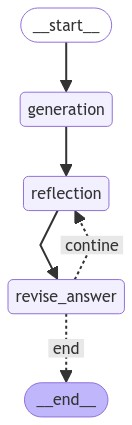

In [55]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

## RUN

In [56]:
MAX_REVISIONS = 2
    
inputs = {"task": "How should we handle the climate crisis?"}
config = {
        "recursion_limit": 50,
        "max_revisions": 2
}

for output in app.stream(inputs, config=config):
    for key, value in output.items():
        print(f"Finished: {key}")

print("Final: ", value["draft"])

selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
Finished: generation
selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
response:  Here are three potential search queries to gather relevant information for the detailed response:

1. "climate change mitigation strategies"
2. "renewable energy transition plans"
3. "carbon pricing policies climate change"
selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
info:  {'raw': AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 371, 'completion_tokens': 52, 'total_tokens': 423}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 371, 'completion_tokens': 52, 'total_tokens': 423}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-ff06c0c3-5f2c-4bab-ad4a-3f0beebd05a8-0', tool_calls=[{'

In [57]:
value['draft'].content

'The summary you provided in the <result> tag covers the key strategies for climate change mitigation and adaptation very well. It highlights the need for a multi-pronged approach involving transitioning to renewable energy, improving energy efficiency, protecting carbon sinks, developing carbon capture technologies, putting a price on emissions, building resilient infrastructure, developing drought-resistant agriculture, managed retreat from high-risk areas, providing financing and technology transfer to developing nations, and unprecedented global cooperation. The goal of dramatically reducing net greenhouse gas emissions to near zero by mid-century to limit the worst climate impacts is also clearly stated. This is a comprehensive and well-structured summary of the main strategies needed to tackle the climate crisis.'

In [58]:
inputs = {"task": "생성형 AI를 이용해 공장의 생산성을 높이는 방법은?"}
config = {
        "recursion_limit": 50,
        "max_revisions": 2
}

for output in app.stream(inputs, config=config):
    for key, value in output.items():
        print(f"Finished: {key}")

print("Final: ", value["draft"])

selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
Finished: generation
selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
response:  생성형 AI를 활용하여 공장의 생산성을 높이는 방법에 대한 정보를 수집하기 위해 다음과 같은 검색어를 사용할 수 있습니다.

1. "AI factory productivity"
2. "predictive maintenance AI manufacturing"
3. "AI vision quality control manufacturing"
selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
info:  {'raw': AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 423, 'completion_tokens': 51, 'total_tokens': 474}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 423, 'completion_tokens': 51, 'total_tokens': 474}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-46696ea2-a0f2-4dad-afe5-4e6172c57273-0', tool_calls=[{'name': 'Queries', 'args': {'queries

In [59]:
value['draft'].content

'요약하신 내용이 매우 포괄적이고 잘 정리되어 있습니다. 생성형 AI가 제조업에서 예측 분석, 예지 정비, 품질 관리, 자동화, 가상 시뮬레이션 등 다양한 측면에서 생산성과 효율성을 높일 수 있는 방안을 잘 제시하셨습니다. 제가 추가할 내용은 없으며, 제시하신 답변이 완벽하다고 생각합니다.'